<a href="https://colab.research.google.com/github/moamenkhalaf97/code/blob/main/Custom%20ocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from imutils.contours import sort_contours
import imutils
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [2]:
network=load_model('/content/network')

In [3]:
network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 2, 128)         0

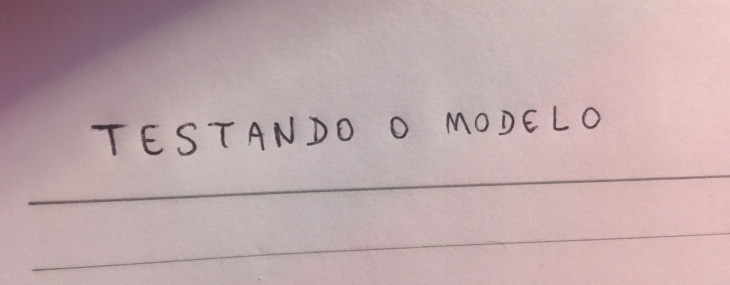

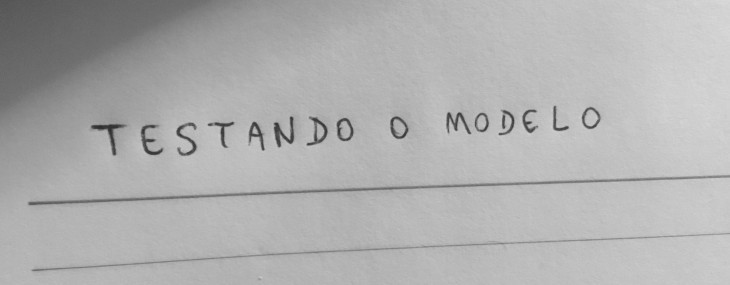

In [4]:
img=cv2.imread('/content/test-manuscript01.jpg')
cv2_imshow(img)
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)

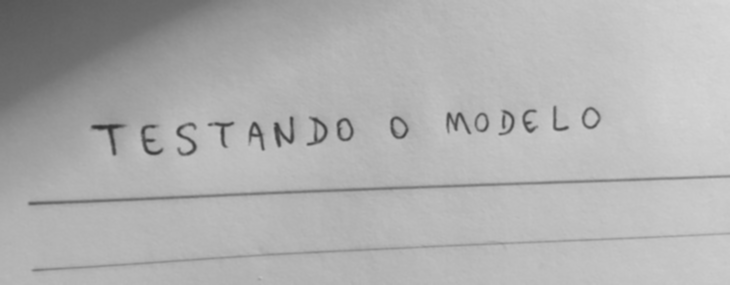

In [5]:
blur=cv2.GaussianBlur(gray,(3,3),0)
cv2_imshow(blur)

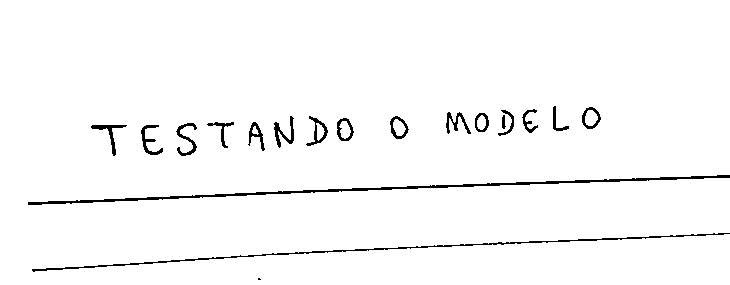

In [6]:
adaptive=cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,9)
cv2_imshow(adaptive)

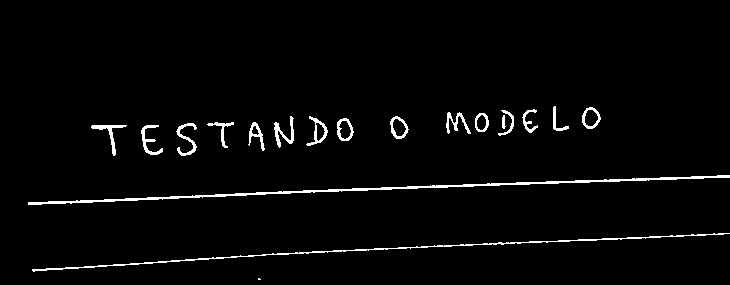

In [7]:
invertion=255-adaptive
cv2_imshow(invertion)

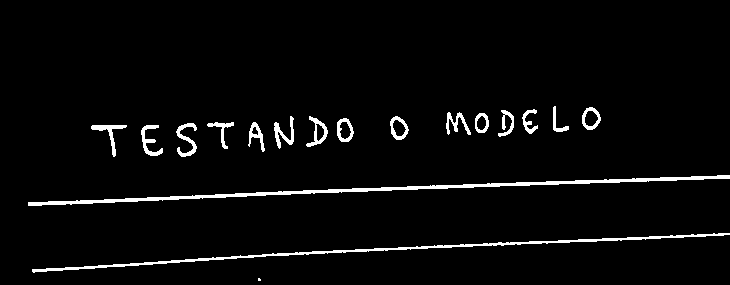

In [8]:
dilation=cv2.dilate(invertion,(3,3),iterations=1)
cv2_imshow(dilation)

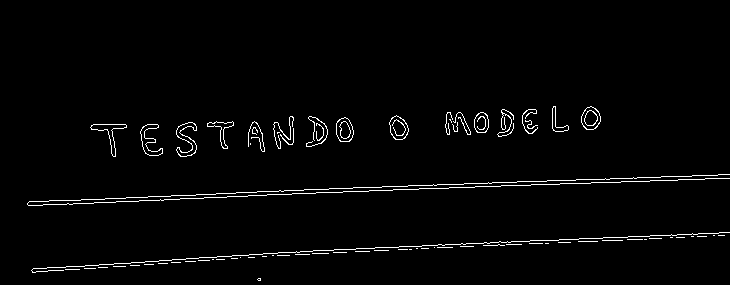

In [9]:
edges=cv2.Canny(dilation,40,150)
cv2_imshow(edges)

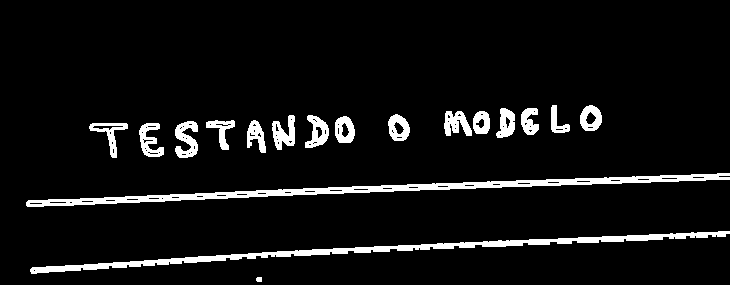

In [10]:
dilation=cv2.dilate(edges,np.ones((3,3)))
cv2_imshow(dilation)

In [12]:
def find_contours(img):
  conts=cv2.findContours(img,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
  conts=imutils.grab_contours(conts)
  conts=sort_contours(conts,method='left-to-right')[0]
  return conts

In [13]:
conts=find_contours(dilation.copy())

In [14]:
conts

(array([[[717, 173]],
 
        [[716, 174]],
 
        [[691, 174]],
 
        [[690, 175]],
 
        [[660, 175]],
 
        [[659, 176]],
 
        [[636, 176]],
 
        [[635, 177]],
 
        [[634, 176]],
 
        [[632, 176]],
 
        [[631, 177]],
 
        [[609, 177]],
 
        [[608, 178]],
 
        [[607, 178]],
 
        [[606, 177]],
 
        [[604, 177]],
 
        [[603, 178]],
 
        [[575, 178]],
 
        [[574, 179]],
 
        [[546, 179]],
 
        [[545, 180]],
 
        [[516, 180]],
 
        [[515, 181]],
 
        [[491, 181]],
 
        [[490, 182]],
 
        [[489, 181]],
 
        [[487, 181]],
 
        [[486, 182]],
 
        [[463, 182]],
 
        [[462, 183]],
 
        [[436, 183]],
 
        [[435, 184]],
 
        [[434, 183]],
 
        [[432, 183]],
 
        [[431, 184]],
 
        [[407, 184]],
 
        [[406, 185]],
 
        [[381, 185]],
 
        [[380, 186]],
 
        [[352, 186]],
 
        [[351, 187]],
 
        [[328, 1

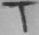

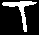

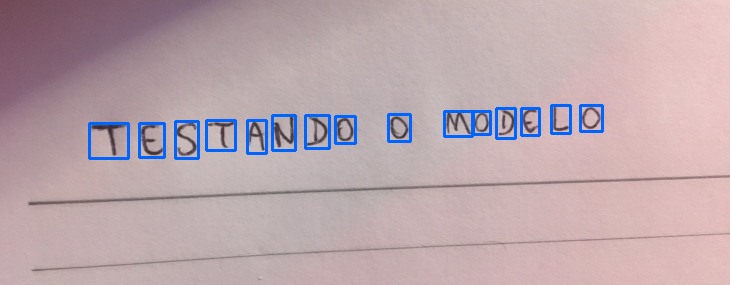

In [15]:
min_w,max_w=4,160
min_h,max_h=14,140
img_copy=img.copy()
for c in conts:
  x,y,w,h=cv2.boundingRect(c)
  ##print(x,y,w,h)
  if(x>=min_w and w<=max_w) and (h>=min_h and h<=max_h):
    roi=gray[y:y+h,x:x+w]
    cv2_imshow(roi)
    thresh=cv2.threshold(roi,0,255,cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)[1]
    cv2_imshow(thresh)
    cv2.rectangle(img_copy,(x,y),(x+w,y+h),(255,100,0),2)
cv2_imshow(img_copy)


In [16]:
def extract_roi(img):
  roi=img[y:y+h,x:x+w]
  return roi


In [17]:
def thresholding(img):
  thresh=cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)[1]
  return thresh

In [18]:
def resize_img(img,w,h):
  if w>h:
    resized=imutils.resize(img,width=28)
  else:
    resized=imutils.resize(img,height=28)
  (w,h)=resized.shape
  dX=int(max(0,28-w)/2.0)
  dY=int(max(0,28-h)/2.0)

  filled=cv2.copyMakeBorder(resized,dY,dY,dX,dX,cv2.BORDER_CONSTANT,value=(0,0,0))
  filled=cv2.resize(filled,(28,28))
  return filled



In [19]:
(x,y,w,h)=cv2.boundingRect(conts[6])
print(x,y,w,h)

247 120 19 33


In [20]:
test_img=thresholding(gray[y:y+h,x:x+w])
cv2_imshow(test_img)
(w,h)=test_img.shape
print(w,h)
test_img2=resize_img(test_img,w,h)
cv2_imshow(test_img2)

33 19


In [21]:
cv2_imshow(cv2.resize(test_img,(28,28)))

In [22]:
def normalization(img):
  img=img.astype('float32')/255.0
  img=np.expand_dims(img,axis=-1)
  return img

In [23]:
test_img2.shape , normalization(test_img2).shape

((28, 28), (28, 28, 1))

In [24]:
characters=[]

In [25]:
def process_box(gray,x,y,w,h):
  roi=extract_roi(gray)
  thresh=thresholding(roi)
  (h,w)=thresh.shape
  resized=resize_img(thresh,w,h)
  cv2_imshow(resized)
  normalized=normalization(resized)
  characters.append((normalized,(x,y,w,h)))


In [26]:
for c in conts:
  (x,y,w,h)=cv2.boundingRect(c)
  if(w>=min_w and w<=max_w) and (h>=min_h and h<=max_h):
     process_box(gray,x,y,w,h)

In [27]:
characters[0]

(array([[[0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.1882353 ],
         [0.28627452],
         [0.28627452],
         [0.28627452],
         [0.28627452],
         [0.28627452],
         [0.28627452],
         [0.28235295],
         [0.10980392],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ]],
 
        [[0.        ],
         [0.        ],
         [0.07058824],
         [0.42352942],
         [0.48235294],
         [0.48235294],
         [0.48235294],
         [0.48235294],
         [0.48235294],
         [0.48235294],
         [0.48235294],
         [0.48235294],
         [0.48235294],
         [0.48235294],
         [0.74509805],
        

In [47]:
boxes=[box[1] for box in characters]
boxes

[(89, 123, 39, 35),
 (139, 123, 25, 34),
 (175, 121, 23, 37),
 (206, 120, 29, 30),
 (247, 120, 19, 33),
 (272, 115, 23, 35),
 (305, 115, 24, 33),
 (335, 116, 20, 27),
 (388, 114, 22, 27),
 (444, 111, 28, 25),
 (473, 111, 17, 23),
 (496, 108, 19, 30),
 (521, 108, 18, 27),
 (551, 105, 19, 28),
 (580, 105, 22, 26)]

In [48]:
pixels=np.array([pixel[0] for pixel in characters],dtype='float32')

In [49]:
pixels

array([[[[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.07058824],
         ...,
         [0.30588236],
         [0.02745098],
         [0.        ]],

        [[0.        ],
         [0.03921569],
         [0.4392157 ],
         ...,
         [0.24705882],
         [0.01568628],
         [0.        ]],

        ...,

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]]],


       [[[0.        ],
         [0.        ],
         [0.  

In [50]:
digits='0123456789'
letters='ABCDEFGHIJKLMNOPQRSTUVWXYZ'
characters_list=digits+letters
characters_list=[L for L in characters_list]

In [51]:
print(characters_list)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [52]:
predictions=network.predict(pixels)

1/1 [==============================] - 0s 20ms/step


In [53]:
predictions

array([[9.43639123e-18, 3.25793316e-11, 8.17270784e-13, 1.46001564e-17,
        2.97016762e-16, 3.81786025e-09, 7.63678265e-14, 2.82803114e-08,
        9.61145920e-12, 2.41768949e-11, 1.51534906e-14, 2.29672683e-12,
        5.04086621e-08, 7.16699589e-10, 1.08167937e-13, 1.84982685e-13,
        4.37684777e-09, 1.10454453e-16, 2.32026690e-11, 9.01013409e-05,
        1.16590222e-08, 3.87927734e-09, 8.94517818e-14, 5.03591363e-13,
        3.75942055e-10, 7.18344983e-09, 7.80743539e-22, 2.54511581e-13,
        1.61735869e-08, 9.99889076e-01, 1.90359915e-05, 3.71851037e-16,
        1.51433559e-17, 8.04593336e-11, 1.56181261e-06, 7.79435325e-08],
       [1.36602926e-14, 3.46318519e-18, 8.39815102e-17, 7.48930350e-31,
        7.71302114e-16, 1.23324059e-11, 9.14734608e-11, 3.58250683e-19,
        1.52906496e-12, 6.97758366e-14, 2.05374505e-14, 2.75692524e-10,
        1.31342983e-06, 1.08677466e-12, 9.99930322e-01, 6.77540957e-05,
        2.58179922e-09, 1.69566685e-13, 5.47389304e-19, 3.40534

In [54]:
predictions.shape

(15, 36)

In [55]:
boxes

[(89, 123, 39, 35),
 (139, 123, 25, 34),
 (175, 121, 23, 37),
 (206, 120, 29, 30),
 (247, 120, 19, 33),
 (272, 115, 23, 35),
 (305, 115, 24, 33),
 (335, 116, 20, 27),
 (388, 114, 22, 27),
 (444, 111, 28, 25),
 (473, 111, 17, 23),
 (496, 108, 19, 30),
 (521, 108, 18, 27),
 (551, 105, 19, 28),
 (580, 105, 22, 26)]

T
T --> 99.9889075756073 %


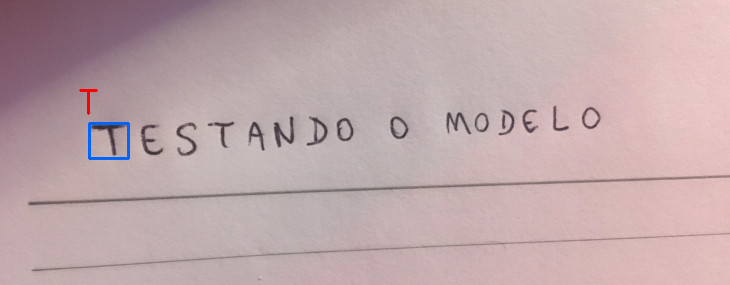

E
E --> 99.99303221702576 %


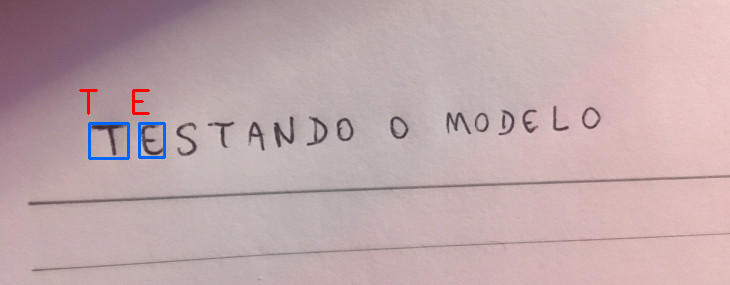

S
S --> 93.57612133026123 %


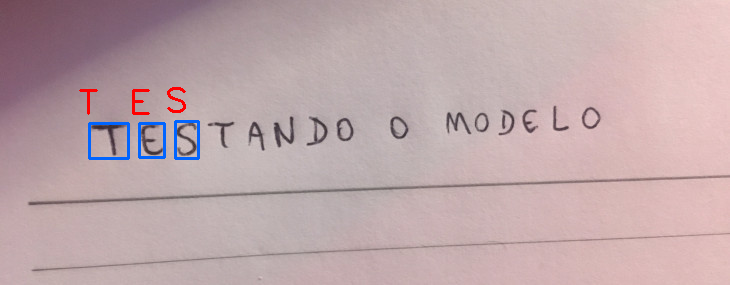

T
T --> 99.99836087226868 %


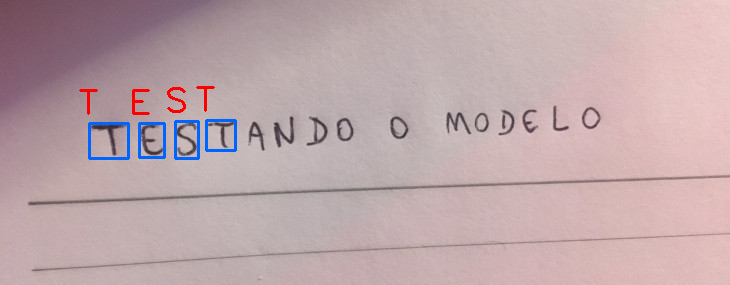

A
A --> 99.99975562095642 %


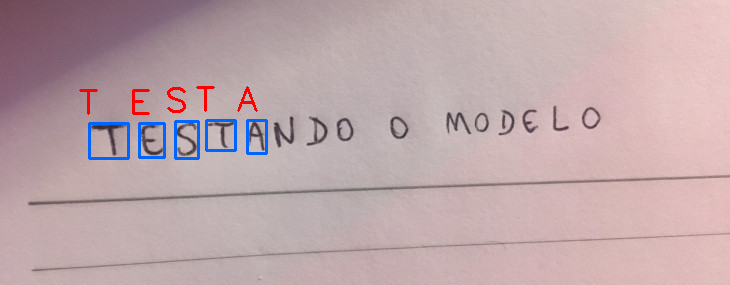

N
N --> 99.90739226341248 %


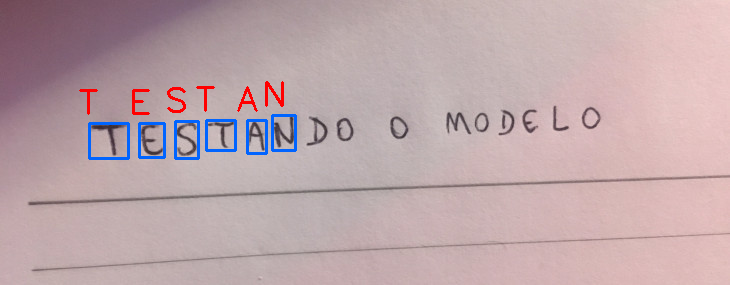

D
D --> 99.99846816062927 %


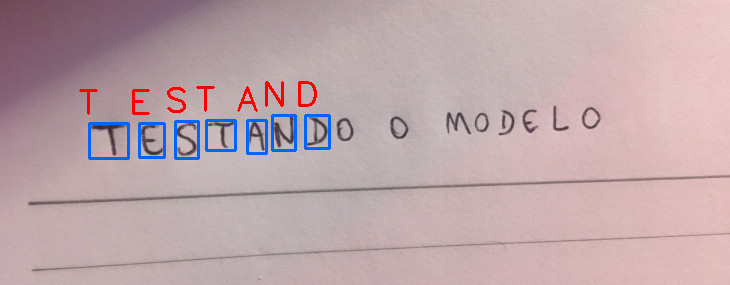

0
0 --> 52.573251724243164 %


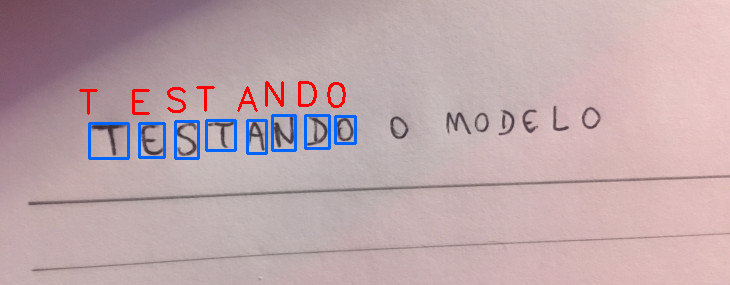

D
D --> 47.771528363227844 %


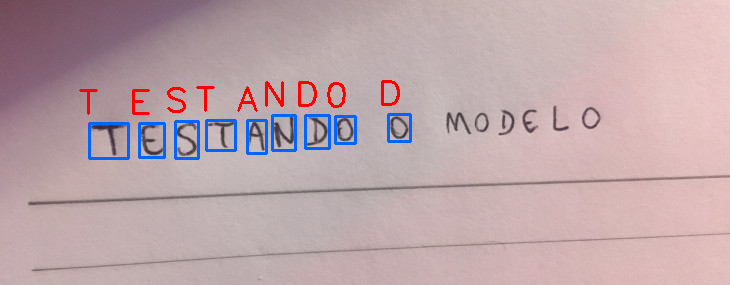

M
M --> 99.3537962436676 %


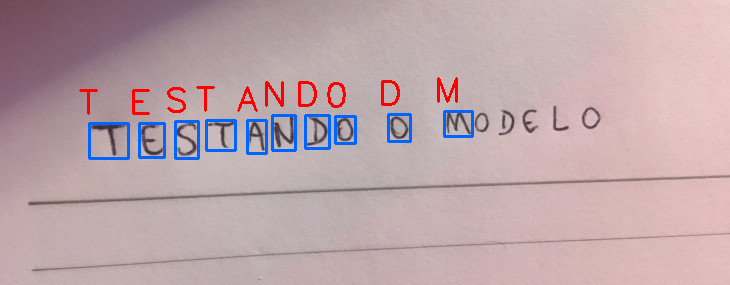

0
0 --> 80.50907254219055 %


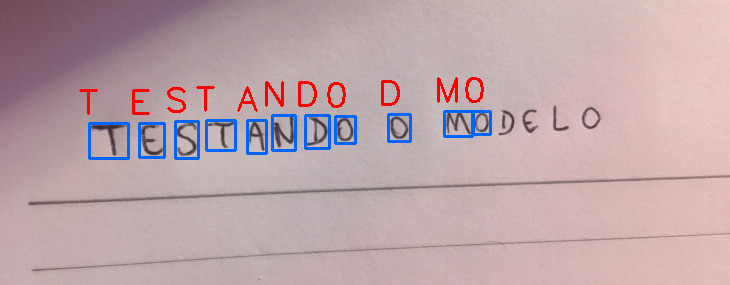

D
D --> 99.94551539421082 %


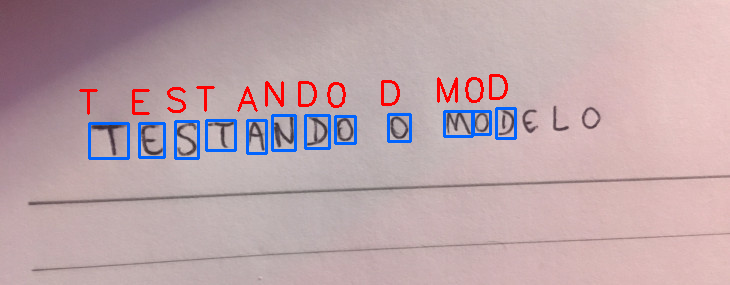

E
E --> 99.98277425765991 %


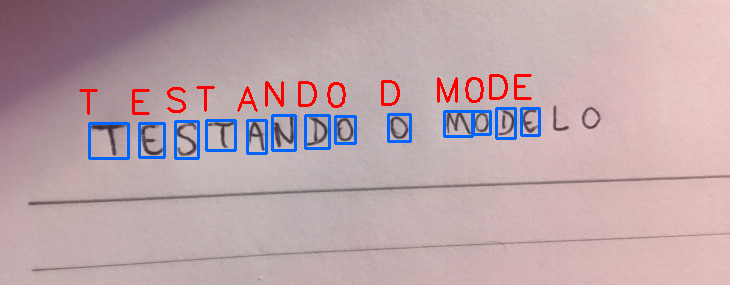

L
L --> 99.99067783355713 %


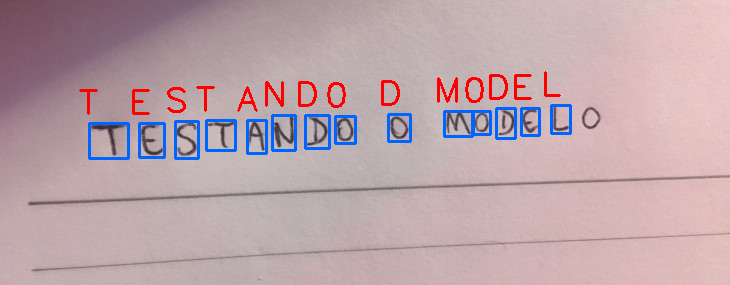

O
O --> 97.3637342453003 %


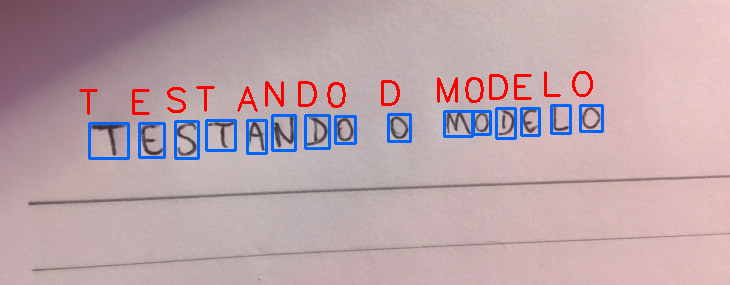

In [64]:
img_copy=img.copy()
for (prediction,(x,y,w,h)) in zip(predictions,boxes):
  i=np.argmax(prediction)
  probability=prediction[i]
  ##print(probability)
  character=characters_list[i]
  print(character)

  cv2.rectangle(img_copy,(x,y),(x+w,y+h),(255,100,0),2)
  cv2.putText(img_copy,character,(x-10,y-10),cv2.FONT_HERSHEY_SIMPLEX,1.1,(0,0,255),2)
  print(character, '-->',probability*100 ,'%')
  cv2_imshow(img_copy)